In [1]:
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
csv_dir = '../../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [3]:
tagged_pitch_types = all_pitches['TaggedPitchType'].unique()
print(tagged_pitch_types)

auto_pitch_types = all_pitches['AutoPitchType'].unique()
print(auto_pitch_types)

['Fastball' 'Slider' 'ChangeUp' 'Curveball' 'Cutter' 'Splitter' 'Sinker'
 'Undefined' 'Other' 'FourSeamFastBall' 'Knuckleball' 'OneSeamFastBall'
 'TwoSeamFastBall']
['Four-Seam' 'Slider' 'Sinker' 'Changeup' 'Curveball' 'Cutter' nan 'Other'
 'Splitter']


In [4]:
fastballs = all_pitches[all_pitches['TaggedPitchType'].isin(['Fastball','Cutter','Sinker','FourSeamFastBall','TwoSeamFastBall','OneSeamFastBall'])]
off_speed = all_pitches[all_pitches['TaggedPitchType'].isin(['ChangeUp','Splitter'])]
breaking_balls = all_pitches[all_pitches['TaggedPitchType'].isin(['Slider','Curveball','Knuckleball'])]

print(fastballs.shape)
print(off_speed.shape)
print(breaking_balls.shape)

(152663, 167)
(31218, 167)
(80860, 167)


In [5]:
fastballs['whiff'] = np.where(fastballs['PitchCall']=='StrikeSwinging',1,0)
off_speed['whiff'] = np.where(off_speed['PitchCall']=='StrikeSwinging',1,0)
breaking_balls['whiff'] = np.where(breaking_balls['PitchCall']=='StrikeSwinging',1,0)

/tmp/ipykernel_18898/2223113172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['whiff'] = np.where(fastballs['PitchCall']=='StrikeSwinging',1,0)
/tmp/ipykernel_18898/2223113172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  off_speed['whiff'] = np.where(off_speed['PitchCall']=='StrikeSwinging',1,0)
/tmp/ipykernel_18898/2223113172.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [6]:
numeric_cols = fastballs.select_dtypes(include=['number']).columns
print(numeric_cols)

Index(['PitchNo', 'PAofInning', 'PitchofPA', 'PitcherId', 'BatterId', 'Inning',
       'Outs', 'Balls', 'Strikes', 'OutsOnPlay',
       ...
       'ThrowTrajectoryXc0', 'ThrowTrajectoryXc1', 'ThrowTrajectoryXc2',
       'ThrowTrajectoryYc0', 'ThrowTrajectoryYc1', 'ThrowTrajectoryYc2',
       'ThrowTrajectoryZc0', 'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2',
       'whiff'],
      dtype='object', length=121)


In [7]:
fb_preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [8]:
fastballs_X = fastballs[fb_preds]
fastballs_y = fastballs['whiff']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(fastballs_X, fastballs_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.76%


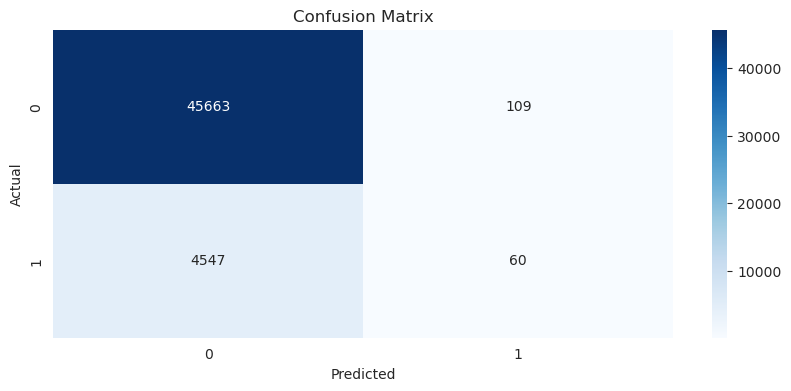

In [10]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.6322
Recall: 0.5053
F1 Score: 0.4883


ROC AUC: 0.5053


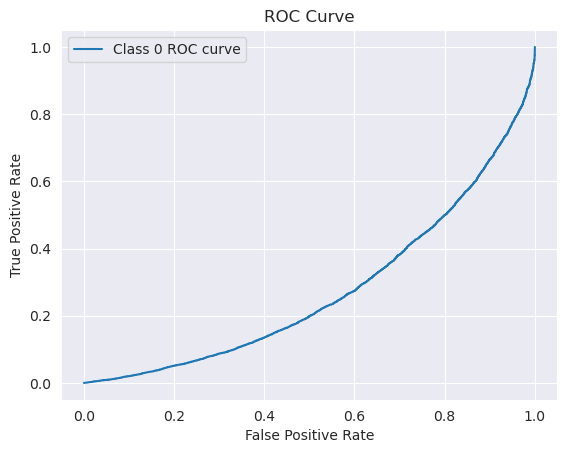

In [12]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 0, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

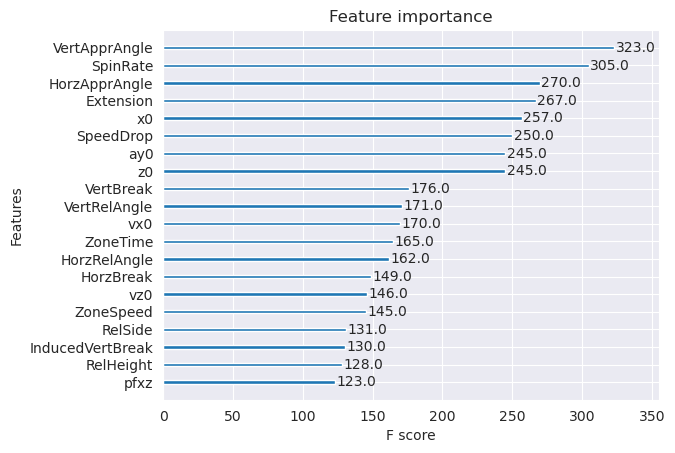

In [13]:
xgboost.plot_importance(model, max_num_features=20)

100%|===================| 101812/102284 [03:26<00:00]       

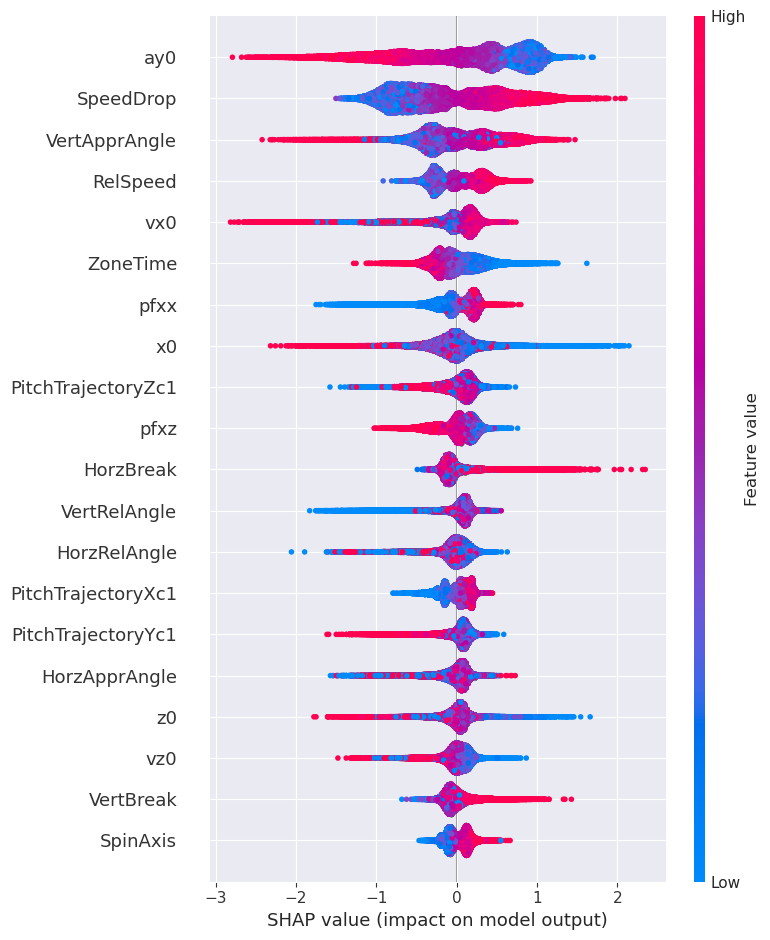

In [14]:
# Step 1: Initialize the SHAP explainer
explainer = shap.Explainer(model, X_train)

# Step 2: Calculate SHAP values for the training data
shap_values = explainer(X_train)

# Step 3: Plot a summary plot
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

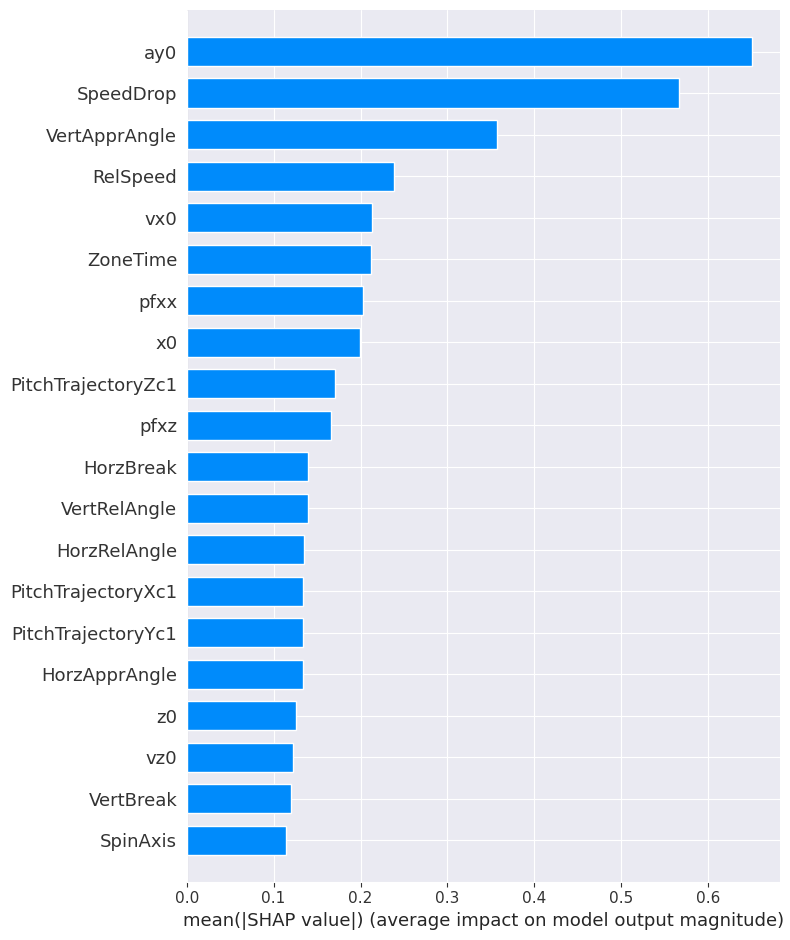

In [15]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type='bar')

In [16]:
aub_fbs = fastballs[fastballs['PitcherTeam']=='AUB_TIG']

In [17]:
# Get unique values
unique_values = fastballs['Pitcher'].unique()
aub_unique_values = aub_fbs['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: fastballs[fastballs['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: aub_fbs[aub_fbs['Pitcher'] == value] for value in aub_unique_values}

['Herberholz, Christian' 'Nelson, Drew' 'Horne, Trevor' 'Olson, Ryan'
 'Carlson, Parker' 'Keshock, Cameron' 'Armstrong, John' 'Vail, Tommy'
 'Bauman, Tanner' 'Cannon, Will' 'Myers, Carson' 'Tilly, Cameron'
 'Allsup, Chase' 'McBride, Connor' 'Isbell, Chase' 'Murphy, Hayden'
 'Graves, Griffin' 'Watts, Dylan' 'Crotchfelt, Zach' 'Copeland, Konner'
 'Petrovic, Alexander' 'Schorr, Ben' 'Gonzalez, Joseph' 'Sheehan, Tommy'
 'Keplinger, Konner']


In [18]:
def aub_fbs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(fastballs_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} Fastball stuff+: {np.mean(stuff * 100)}")

In [19]:
for pitcher in aub_unique_values:
    aub_fbs_stuff(pitcher)

Herberholz, Christian Fastball stuff+: 110.86296081542969
Nelson, Drew Fastball stuff+: 101.11399841308594
Horne, Trevor Fastball stuff+: 91.34375762939453
Olson, Ryan Fastball stuff+: 62.62681579589844
Carlson, Parker Fastball stuff+: 79.9603271484375
Keshock, Cameron Fastball stuff+: 81.00540924072266
Armstrong, John Fastball stuff+: 79.28062438964844
Vail, Tommy Fastball stuff+: 175.55616760253906
Bauman, Tanner Fastball stuff+: 84.06635284423828
Cannon, Will Fastball stuff+: 116.53824615478516
Myers, Carson Fastball stuff+: 69.5983657836914
Tilly, Cameron Fastball stuff+: 104.74772644042969
Allsup, Chase Fastball stuff+: 131.9665069580078
McBride, Connor Fastball stuff+: 128.30323791503906
Isbell, Chase Fastball stuff+: 92.41439056396484
Murphy, Hayden Fastball stuff+: 84.96248626708984
Graves, Griffin Fastball stuff+: 137.90672302246094
Watts, Dylan Fastball stuff+: 85.34577941894531
Crotchfelt, Zach Fastball stuff+: 133.66171264648438
Copeland, Konner Fastball stuff+: 83.71119689

Now, we can save the model to be accessed by the dash app

In [21]:
import joblib

joblib.dump(model, '../../models/fastballs_model.pkl')

['../../models/fastballs_model.pkl']